In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## 1. Chargement des données

In [5]:
path = '/code/data/archive/'
df = pd.read_csv(path + 'training.1600000.processed.noemoticon.csv', sep=',',  encoding='latin-1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [6]:
# Mettre un header au dataframe
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [7]:
# Voir les valeurs uniques du dataframe
df.nunique()

target          2
ids       1598314
date       774362
flag            1
user       659775
text      1581465
dtype: int64

In [8]:
# Voir si il y a des valeurs manquantes
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

### Distribion des valeurs de la colonne 'target' .

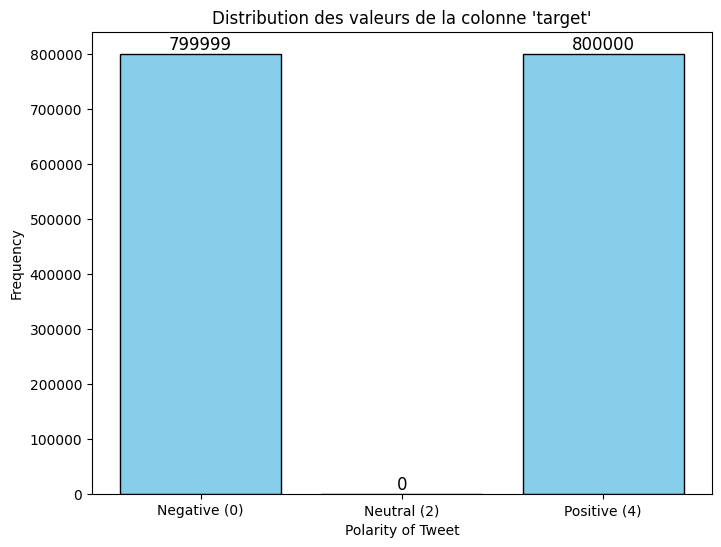

In [13]:
# Créer un histogramme des valeurs de la colonne 'target' avec des étiquettes spécifiques et le nombre total de valeurs

# Compter les occurrences de chaque valeur unique dans 'target' avec les valeurs 0, 2, et 4
target_counts = df['target'].value_counts().reindex([0, 2, 4], fill_value=0)

# Configurer le graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(['Negative (0)', 'Neutral (2)', 'Positive (4)'], target_counts, color='skyblue', edgecolor='black')

# Ajouter les annotations (le nombre total au-dessus de chaque colonne)
for bar, count in zip(bars, target_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count}', ha='center', va='bottom', fontsize=12)

# Personnaliser l'apparence du graphique
plt.title("Distribution des valeurs de la colonne 'target'")
plt.xlabel("Polarity of Tweet")
plt.ylabel("Frequency")
plt.show()

### Analyse du graphique

Le graphique ci-dessus montre la distribution des valeurs de la colonne `target` dans votre dataset de tweets, qui est utilisé pour l'analyse de sentiments. Voici une analyse détaillée :

1. **Distribution des sentiments** : Le graphique indique qu'il y a deux catégories majoritaires :
   - **Negative (0)** : 799,999 tweets
   - **Positive (4)** : 800,000 tweets
   - **Neutral (2)** : Aucun tweet n'est présent dans cette catégorie.

   Cela signifie que le dataset est composé exclusivement de sentiments polarisés, soit négatifs, soit positifs, sans tweets neutres. Cela pourrait poser un défi pour les modèles d'apprentissage, car ils ne verront aucune donnée pour la catégorie "neutre".

2. **Équilibre des classes** : Les deux classes `Negative` et `Positive` sont presque parfaitement équilibrées, avec seulement un tweet de différence. Cet équilibre est avantageux pour l'apprentissage supervisé car il minimise les risques de biais en faveur d'une classe spécifique.

3. **Données manquantes** : L'absence de tweets neutres (valeur `2`) peut poser problème si l'on souhaite modéliser ou prédire cette classe. Si une détection de sentiment neutre est requise, il serait idéal de compléter le dataset avec des tweets de cette catégorie.

### Conclusion

Le graphique de distribution des valeurs de la colonne `target` montre une absence de tweets neutres (valeur `2`). Étant donné que seules les catégories **Negative (0)** et **Positive (4)** sont présentes en quantités équilibrées, il est judicieux de simplifier le problème en une **classification binaire** entre sentiments négatifs et positifs.

Cette approche de classification binaire sera plus efficace, car il n'y a pas de données pour entraîner un modèle à détecter les tweets neutres.
